In [1]:
# This notebook uses sympy to calculate the appropriate coefficients 
# for the derivative stencils for the various cases used in engrenage, 
# and checks the Grid and Derivative classes work as expected

# restart the kernel to clear past work
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
import numpy as np
from sympy import symbols, simplify, pprint, diff, expand, collect, finite_diff_weights, apply_finite_diff
import matplotlib.pyplot as plt
import sys
%matplotlib inline

sys.path.append('../')
from source.Grid import *

In [3]:
# Set up a Grid class where the spacing is 1 evenly, check results for stencils
max_r = 10.5
num_points = 14
log_factor = 1.0
my_grid = Grid(max_r, num_points, log_factor)
print(my_grid.derivatives.r_vector)
print(12*my_grid.derivatives.d1_stencil)
print(12*my_grid.derivatives.d2_stencil)
print(6*my_grid.derivatives.advec_d1_stencil_left)
print(6*my_grid.derivatives.advec_d1_stencil_right)
print(my_grid.derivatives.advec_d2_stencil_left)
print(my_grid.derivatives.advec_d2_stencil_right)
print(64*my_grid.derivatives.dissipation_derivative_stencil)

[-2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]
[ 1. -8.  0.  8. -1.]
[ -1.  16. -30.  16.  -1.]
[ -2.   9. -18.  11.]
[-11.  18.  -9.   2.]
[-1.  4. -5.  2.]
[ 2. -5.  4. -1.]
[   64.  -384.   960. -1280.   960.  -384.    64.]


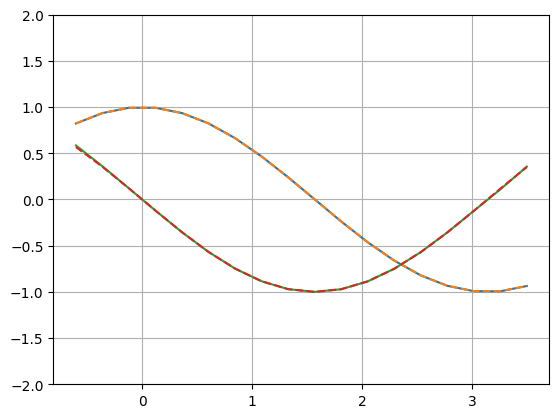

In [4]:
# Now test the derivatives on a function
# Set up a Grid class where the spacing is 1 evenly, check result
max_r = 3.5
num_points = 18
log_factor = 1.0
my_grid = Grid(max_r, num_points, log_factor)
#print(my_grid.derivatives.r_vector)
r = my_grid.r_vector
y = np.sin(r)
dydr = np.dot(my_grid.derivatives.d1_matrix, y)

plt.plot(r, dydr, '-')
plt.plot(r, np.cos(r), '--')

d2ydr2 = np.dot(my_grid.derivatives.d2_matrix, y)

plt.plot(r, d2ydr2, '-')
plt.plot(r, -np.sin(r), '--')

plt.ylim([-2,2])
plt.grid()

In [5]:
# Check the finite derivatives for a fixed spacing dx, centered derivative
# using 5 points (so O(dx^4) accurate)

# Construct the polynomial using sympy
x = symbols('x')
deltax = symbols('dx')
x3 = symbols('x3')
x2 = x3-deltax
x1 = x2-deltax
x4 = x3+deltax
x5 = x4+deltax
f1 = symbols('f1')
f2 = symbols('f2')
f3 = symbols('f3')
f4 = symbols('f4')
f5 = symbols('f5')

L1 = (x - x2 ) / (x1 - x2) * (x - x3 ) / (x1 - x3)* (x - x4) / (x1 - x4) * (x - x5 ) / (x1 - x5)
L2 = (x - x1 ) / (x2 - x1) * (x - x3 ) / (x2 - x3)* (x - x4 ) / (x2 - x4)* (x - x5 ) / (x2 - x5)
L3 = (x - x1 ) / (x3 - x1) * (x - x2 ) / (x3 - x2)* (x - x4 ) / (x3 - x4)* (x - x5 ) / (x3 - x5)
L4 = (x - x1 ) / (x4 - x1) * (x - x2 ) / (x4 - x2)* (x - x3 ) / (x4 - x3)* (x - x5 ) / (x4 - x5)
L5 = (x - x1 ) / (x5 - x1) * (x - x2 ) / (x5 - x2)* (x - x3 ) / (x5 - x3)* (x - x4 ) / (x5 - x4)
P = f1 * L1 + f2 * L2 + f3 * L3 + f4 * L4 + f5 * L5
#print("Using sympy we get the polynomial", simplify(P))
#pprint(simplify(P))

# Now take the derivative twice
dPdx = diff(P, x)
#print("Its first derivative is", simplify(dPdx))

d2Pdx2 = diff(dPdx, x)
#print("Its second derivative is", simplify(d2Pdx2))
#pprint(simplify(dPdx))

# Now find the value at the central point x3
dPdx_at_x3 = dPdx.subs(x, x3)
d2Pdx2_at_x3 = d2Pdx2.subs(x, x3)
print("Its first derivative at x3 is", simplify(dPdx_at_x3))
print("Its second derivative at x3 is", simplify(d2Pdx2_at_x3))
print("This gives the first derivative stencil \n")
pprint(simplify(dPdx_at_x3))
print("This gives the second derivative stencil \n")
pprint(simplify(d2Pdx2_at_x3))

Its first derivative at x3 is (f1 - 8*f2 + 8*f4 - f5)/(12*dx)
Its second derivative at x3 is (-f1 + 16*f2 - 30*f3 + 16*f4 - f5)/(12*dx**2)
This gives the first derivative stencil 

f₁ - 8⋅f₂ + 8⋅f₄ - f₅
─────────────────────
        12⋅dx        
This gives the second derivative stencil 

-f₁ + 16⋅f₂ - 30⋅f₃ + 16⋅f₄ - f₅
────────────────────────────────
                  2             
             12⋅dx              


In [6]:
# Now for the logarithmic case

# Check the finite derivatives for log factor of c, centered derivative
# using 5 points (so O(dx^4) accurate)

# Construct the polynomial using sympy
x = symbols('x')
c = symbols('c')
dx = symbols('dx')
x1 = dx/2
x2 = x1+(c*dx)
x3 = x2+(c*c*dx)
x4 = x3+(c*c*c*dx)
x5 = x4+(c*c*c*c*dx)
f1 = symbols('f1')
f2 = symbols('f2')
f3 = symbols('f3')
f4 = symbols('f4')
f5 = symbols('f5')

L1 = (x - x2 ) / (x1 - x2) * (x - x3 ) / (x1 - x3)* (x - x4) / (x1 - x4) * (x - x5 ) / (x1 - x5)
L2 = (x - x1 ) / (x2 - x1) * (x - x3 ) / (x2 - x3)* (x - x4 ) / (x2 - x4)* (x - x5 ) / (x2 - x5)
L3 = (x - x1 ) / (x3 - x1) * (x - x2 ) / (x3 - x2)* (x - x4 ) / (x3 - x4)* (x - x5 ) / (x3 - x5)
L4 = (x - x1 ) / (x4 - x1) * (x - x2 ) / (x4 - x2)* (x - x3 ) / (x4 - x3)* (x - x5 ) / (x4 - x5)
L5 = (x - x1 ) / (x5 - x1) * (x - x2 ) / (x5 - x2)* (x - x3 ) / (x5 - x3)* (x - x4 ) / (x5 - x4)
P = f1 * L1 + f2 * L2 + f3 * L3 + f4 * L4 + f5 * L5
#print("Using sympy we get the polynomial", simplify(P))
#pprint(simplify(P))

# Now take the derivative twice
dPdx = diff(P, x)
#print("Its first derivative is", simplify(dPdx))

d2Pdx2 = diff(dPdx, x)
#print("Its second derivative is", simplify(d2Pdx2))
#pprint(simplify(dPdx))

# Now find the value at the central point x3
dPdx_at_x3 = dPdx.subs(x, x3)
d2Pdx2_at_x3 = d2Pdx2.subs(x, x3)
#print("Its first derivative at x2 is", simplify(dPdx_at_x3))
#print("Its second derivative at x2 is", simplify(d2Pdx2_at_x3))
#print("This gives the first derivative stencil \n")
#pprint(simplify(dPdx_at_x3))
#print("This gives the second derivative stencil \n")
#pprint(simplify(d2Pdx2_at_x3))

# Easier to isolate out the terms one by one - coeff of f5 first
f5_dPdx_at_x3 = dPdx_at_x3.subs(f1, 0)
f5_dPdx_at_x3 = f5_dPdx_at_x3.subs(f2, 0)
f5_dPdx_at_x3 = f5_dPdx_at_x3.subs(f3, 0)
f5_dPdx_at_x3 = f5_dPdx_at_x3.subs(f4, 0)
f5_dPdx_at_x3 = simplify(f5_dPdx_at_x3)
dR_at_x3 = (c*c*dx)
print("The coefficient of the f5 term in the first derivative stencil is \n")
pprint(f5_dPdx_at_x3 * dR_at_x3)

print("\n In the case where c is 1 we can check it matches the above:")
pprint(simplify(((dPdx_at_x3 * dR_at_x3).subs(c,1))))

The coefficient of the f5 term in the first derivative stencil is 

               -f₅               
─────────────────────────────────
 2 ⎛ 2        ⎞ ⎛ 3    2        ⎞
c ⋅⎝c  + c + 1⎠⋅⎝c  + c  + c + 1⎠

 In the case where c is 1 we can check it matches the above:
f₁   2⋅f₂   2⋅f₄   f₅
── - ──── + ──── - ──
12    3      3     12


In [7]:
# check the form matches the simpler one used in the code
# (sympy not great at simplifying)
check = -f5/(c**2 * (1 + c) *(1 + c**2) * (1 + c + c**2))
simplify(f5_dPdx_at_x3 * dR_at_x3 - check)

0

In [8]:
# Same for second derivs - coeff of f5 first
f5_d2Pdx2_at_x3 = d2Pdx2_at_x3.subs(f1, 0)
f5_d2Pdx2_at_x3 = f5_d2Pdx2_at_x3.subs(f2, 0)
f5_d2Pdx2_at_x3 = f5_d2Pdx2_at_x3.subs(f3, 0)
f5_d2Pdx2_at_x3 = f5_d2Pdx2_at_x3.subs(f4, 0)
f5_d2Pdx2_at_x3 = simplify(f5_d2Pdx2_at_x3)
dR_at_x3 = (c*c*dx)
print("The coefficient of the f5 term in the first derivative stencil is \n")
pprint(simplify(f5_d2Pdx2_at_x3 * dR_at_x3 * dR_at_x3))

The coefficient of the f5 term in the first derivative stencil is 

           ⎛ 2                    ⎞      
     -2⋅f₅⋅⎝c  + c⋅(c + 1) - c - 1⎠      
─────────────────────────────────────────
 3         ⎛ 2        ⎞ ⎛ 3    2        ⎞
c ⋅(c + 1)⋅⎝c  + c + 1⎠⋅⎝c  + c  + c + 1⎠


In [9]:
# Check the finite derivatives for one sided derivs with 4 points
# using 4 points (so O(dx^3) accurate)

# Construct the polynomial using sympy
x = symbols('x')
c = symbols('c')
dx = symbols('dx')
x1 = dx/2
x2 = x1+(c*dx)
x3 = x2+(c*c*dx)
x4 = x3+(c*c*c*dx)
f1 = symbols('f1')
f2 = symbols('f2')
f3 = symbols('f3')
f4 = symbols('f4')

L1 = (x - x2 ) / (x1 - x2) * (x - x3 ) / (x1 - x3)* (x - x4) / (x1 - x4) 
L2 = (x - x1 ) / (x2 - x1) * (x - x3 ) / (x2 - x3)* (x - x4 ) / (x2 - x4)
L3 = (x - x1 ) / (x3 - x1) * (x - x2 ) / (x3 - x2)* (x - x4 ) / (x3 - x4)
L4 = (x - x1 ) / (x4 - x1) * (x - x2 ) / (x4 - x2)* (x - x3 ) / (x4 - x3)
P = f1 * L1 + f2 * L2 + f3 * L3 + f4 * L4
#print("Using sympy we get the polynomial", simplify(P))
#pprint(simplify(P))

# Now take the derivative twice
dPdx = diff(P, x)
#print("Its first derivative is", simplify(dPdx))

d2Pdx2 = diff(dPdx, x)
#print("Its second derivative is", simplify(d2Pdx2))
#pprint(simplify(dPdx))

# Now find the value at the end point x4 for d1
dPdx_at_x4 = dPdx.subs(x, x4)
# Easier to isolate out the terms one by one - coeff of f1 first
f1_dPdx_at_x4 = dPdx_at_x4.subs(f2, 0)
f1_dPdx_at_x4 = f1_dPdx_at_x4.subs(f3, 0)
f1_dPdx_at_x4 = f1_dPdx_at_x4.subs(f4, 0)
f1_dPdx_at_x4 = simplify(f1_dPdx_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f1 term in the first derivative stencil is \n")
pprint(f1_dPdx_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f2
f2_dPdx_at_x4 = dPdx_at_x4.subs(f1, 0)
f2_dPdx_at_x4 = f2_dPdx_at_x4.subs(f3, 0)
f2_dPdx_at_x4 = f2_dPdx_at_x4.subs(f4, 0)
f2_dPdx_at_x4 = simplify(f2_dPdx_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f2 term in the first derivative stencil is \n")
pprint(f2_dPdx_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f3
f3_dPdx_at_x4 = dPdx_at_x4.subs(f1, 0)
f3_dPdx_at_x4 = f3_dPdx_at_x4.subs(f2, 0)
f3_dPdx_at_x4 = f3_dPdx_at_x4.subs(f4, 0)
f3_dPdx_at_x4 = simplify(f3_dPdx_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f3 term in the first derivative stencil is \n")
pprint(f3_dPdx_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f4
f4_dPdx_at_x4 = dPdx_at_x4.subs(f1, 0)
f4_dPdx_at_x4 = f4_dPdx_at_x4.subs(f2, 0)
f4_dPdx_at_x4 = f4_dPdx_at_x4.subs(f3, 0)
f4_dPdx_at_x4 = simplify(f4_dPdx_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f4 term in the first derivative stencil is \n")
pprint(f4_dPdx_at_x4 * dR_at_x4)

The coefficient of the f1 term in the first derivative stencil is 

   5      
 -c ⋅f₁   
──────────
 2        
c  + c + 1
The coefficient of the f2 term in the first derivative stencil is 

 2    ⎛ 2        ⎞
c ⋅f₂⋅⎝c  + c + 1⎠
──────────────────
      c + 1       
The coefficient of the f3 term in the first derivative stencil is 

    ⎛ 2        ⎞
-f₃⋅⎝c  + c + 1⎠
The coefficient of the f4 term in the first derivative stencil is 

   ⎛   3      2          ⎞
f₄⋅⎝3⋅c  + 4⋅c  + 3⋅c + 1⎠
──────────────────────────
    3      2              
   c  + 2⋅c  + 2⋅c + 1    


In [10]:
# Now find the value at the end point x4 for d2
d2Pdx2_at_x4 = d2Pdx2.subs(x, x4)
# Easier to isolate out the terms one by one - coeff of f1 first
f1_d2Pdx2_at_x4 = d2Pdx2_at_x4.subs(f2, 0)
f1_d2Pdx2_at_x4 = f1_d2Pdx2_at_x4.subs(f3, 0)
f1_d2Pdx2_at_x4 = f1_d2Pdx2_at_x4.subs(f4, 0)
f1_d2Pdx2_at_x4 = simplify(f1_d2Pdx2_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f1 term in the 2nd derivative stencil is \n")
pprint(f1_d2Pdx2_at_x4 * dR_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f2
f2_d2Pdx2_at_x4 = d2Pdx2_at_x4.subs(f1, 0)
f2_d2Pdx2_at_x4 = f2_d2Pdx2_at_x4.subs(f3, 0)
f2_d2Pdx2_at_x4 = f2_d2Pdx2_at_x4.subs(f4, 0)
f2_d2Pdx2_at_x4 = simplify(f2_d2Pdx2_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f2 term in the 2nd derivative stencil is \n")
pprint(f2_d2Pdx2_at_x4 * dR_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f3
f3_d2Pdx2_at_x4 = d2Pdx2_at_x4.subs(f1, 0)
f3_d2Pdx2_at_x4 = f3_d2Pdx2_at_x4.subs(f2, 0)
f3_d2Pdx2_at_x4 = f3_d2Pdx2_at_x4.subs(f4, 0)
f3_d2Pdx2_at_x4 = simplify(f3_d2Pdx2_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f3 term in the 2nd derivative stencil is \n")
pprint(f3_d2Pdx2_at_x4 * dR_at_x4 * dR_at_x4)

# Easier to isolate out the terms one by one - coeff of f4
f4_d2Pdx2_at_x4 = d2Pdx2_at_x4.subs(f1, 0)
f4_d2Pdx2_at_x4 = f4_d2Pdx2_at_x4.subs(f2, 0)
f4_d2Pdx2_at_x4 = f4_d2Pdx2_at_x4.subs(f3, 0)
f4_d2Pdx2_at_x4 = simplify(f4_d2Pdx2_at_x4)
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f4 term in the 2nd derivative stencil is \n")
pprint(f4_d2Pdx2_at_x4 * dR_at_x4 * dR_at_x4)

The coefficient of the f1 term in the 2nd derivative stencil is 

    5               
 2⋅c ⋅f₁⋅(-2⋅c - 1) 
────────────────────
        ⎛ 2        ⎞
(c + 1)⋅⎝c  + c + 1⎠
The coefficient of the f2 term in the 2nd derivative stencil is 

   2    ⎛   2        ⎞
2⋅c ⋅f₂⋅⎝2⋅c  + c + 1⎠
──────────────────────
        c + 1         
The coefficient of the f3 term in the 2nd derivative stencil is 

       ⎛     2          ⎞
2⋅c⋅f₃⋅⎝- 2⋅c  - 2⋅c - 1⎠
─────────────────────────
          c + 1          
The coefficient of the f4 term in the 2nd derivative stencil is 

       ⎛   2                    ⎞
2⋅c⋅f₄⋅⎝2⋅c  + c⋅(c + 1) + c + 1⎠
─────────────────────────────────
               ⎛ 2        ⎞      
       (c + 1)⋅⎝c  + c + 1⎠      


In [11]:
# Now find the value at the end point x1 for d1

dPdx_at_x1 = dPdx.subs(x, x1)
# Easier to isolate out the terms one by one - coeff of f1 first
f1_dPdx_at_x1 = dPdx_at_x1.subs(f2, 0)
f1_dPdx_at_x1 = f1_dPdx_at_x1.subs(f3, 0)
f1_dPdx_at_x1 = f1_dPdx_at_x1.subs(f4, 0)
f1_dPdx_at_x1 = simplify(f1_dPdx_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f1 term in the first derivative stencil is \n")
pprint(f1_dPdx_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f2
f2_dPdx_at_x1 = dPdx_at_x1.subs(f1, 0)
f2_dPdx_at_x1 = f2_dPdx_at_x1.subs(f3, 0)
f2_dPdx_at_x1 = f2_dPdx_at_x1.subs(f4, 0)
f2_dPdx_at_x1 = simplify(f2_dPdx_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f2 term in the first derivative stencil is \n")
pprint(f2_dPdx_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f3
f3_dPdx_at_x1 = dPdx_at_x1.subs(f1, 0)
f3_dPdx_at_x1 = f3_dPdx_at_x1.subs(f2, 0)
f3_dPdx_at_x1 = f3_dPdx_at_x1.subs(f4, 0)
f3_dPdx_at_x1 = simplify(f3_dPdx_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f3 term in the first derivative stencil is \n")
pprint(f3_dPdx_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f4
f4_dPdx_at_x1 = dPdx_at_x1.subs(f1, 0)
f4_dPdx_at_x1 = f4_dPdx_at_x1.subs(f2, 0)
f4_dPdx_at_x1 = f4_dPdx_at_x1.subs(f3, 0)
f4_dPdx_at_x1 = simplify(f4_dPdx_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f4 term in the first derivative stencil is \n")
pprint(f4_dPdx_at_x1 * dR_at_x1)

The coefficient of the f1 term in the first derivative stencil is 

   ⎛   3      2          ⎞
f₁⋅⎝- c  - 3⋅c  - 4⋅c - 3⎠
──────────────────────────
   ⎛ 3      2          ⎞  
 c⋅⎝c  + 2⋅c  + 2⋅c + 1⎠  
The coefficient of the f2 term in the first derivative stencil is 

   ⎛ 2        ⎞
f₂⋅⎝c  + c + 1⎠
───────────────
        3      
       c       
The coefficient of the f3 term in the first derivative stencil is 

    ⎛ 2        ⎞ 
-f₃⋅⎝c  + c + 1⎠ 
─────────────────
     4           
    c ⋅(c + 1)   
The coefficient of the f4 term in the first derivative stencil is 

       f₄      
───────────────
 4 ⎛ 2        ⎞
c ⋅⎝c  + c + 1⎠


In [12]:
# Now find the value at the end point x1 for d2
d2Pdx2_at_x1 = d2Pdx2.subs(x, x1)
# Easier to isolate out the terms one by one - coeff of f1 first
f1_d2Pdx2_at_x1 = d2Pdx2_at_x1.subs(f2, 0)
f1_d2Pdx2_at_x1 = f1_d2Pdx2_at_x1.subs(f3, 0)
f1_d2Pdx2_at_x1 = f1_d2Pdx2_at_x1.subs(f4, 0)
f1_d2Pdx2_at_x1 = simplify(f1_d2Pdx2_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f1 term in the 2nd derivative stencil is \n")
pprint(f1_d2Pdx2_at_x1 * dR_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f2
f2_d2Pdx2_at_x1 = d2Pdx2_at_x1.subs(f1, 0)
f2_d2Pdx2_at_x1 = f2_d2Pdx2_at_x1.subs(f3, 0)
f2_d2Pdx2_at_x1 = f2_d2Pdx2_at_x1.subs(f4, 0)
f2_d2Pdx2_at_x1 = simplify(f2_d2Pdx2_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f2 term in the 2nd derivative stencil is \n")
pprint(f2_d2Pdx2_at_x1 * dR_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f3
f3_d2Pdx2_at_x1 = d2Pdx2_at_x1.subs(f1, 0)
f3_d2Pdx2_at_x1 = f3_d2Pdx2_at_x1.subs(f2, 0)
f3_d2Pdx2_at_x1 = f3_d2Pdx2_at_x1.subs(f4, 0)
f3_d2Pdx2_at_x1 = simplify(f3_d2Pdx2_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f3 term in the 2nd derivative stencil is \n")
pprint(f3_d2Pdx2_at_x1 * dR_at_x1 * dR_at_x1)

# Easier to isolate out the terms one by one - coeff of f4
f4_d2Pdx2_at_x1 = d2Pdx2_at_x1.subs(f1, 0)
f4_d2Pdx2_at_x1 = f4_d2Pdx2_at_x1.subs(f2, 0)
f4_d2Pdx2_at_x1 = f4_d2Pdx2_at_x1.subs(f3, 0)
f4_d2Pdx2_at_x1 = simplify(f4_d2Pdx2_at_x1)
dR_at_x1 = (dx)
print("The coefficient of the f4 term in the 2nd derivative stencil is \n")
pprint(f4_d2Pdx2_at_x1 * dR_at_x1 * dR_at_x1)

The coefficient of the f1 term in the 2nd derivative stencil is 

       ⎛ 2          ⎞  
  2⋅f₁⋅⎝c  + 2⋅c + 3⎠  
───────────────────────
 2         ⎛ 2        ⎞
c ⋅(c + 1)⋅⎝c  + c + 1⎠
The coefficient of the f2 term in the 2nd derivative stencil is 

     ⎛   2          ⎞
2⋅f₂⋅⎝- c  - 2⋅c - 2⎠
─────────────────────
       4             
      c ⋅(c + 1)     
The coefficient of the f3 term in the 2nd derivative stencil is 

     ⎛ 2        ⎞
2⋅f₃⋅⎝c  + c + 2⎠
─────────────────
     5           
    c ⋅(c + 1)   
The coefficient of the f4 term in the 2nd derivative stencil is 

     2⋅f₄⋅(-c - 2)     
───────────────────────
 5         ⎛ 2        ⎞
c ⋅(c + 1)⋅⎝c  + c + 1⎠


In [13]:
# Now we use a polynomial based on the first 4 points above r=0 to interpolate 
# the values at xA = -dx/2, xB = -(dx/2 + dx/c), xC = -(dx/2 + dx/c + dx/c/c)
# assuming (even) symmetry in r -> - r (parity to be dealt with per variable)

# Check that polynomial gives right value for the first point below r=0, xA 
# (should just be same as value at x1, so f1)
P_at_xA = P.subs(x, dx/2)
pprint(P_at_xA)

f₁


In [14]:
# Check that polynomial gives right value for the second point below r=0, xB 
P_at_xB = P.subs(x, dx/2 + dx/c)
#pprint(simplify(P_at_xm1))
# Easier to isolate out the terms one by one - coeff of f1 first
coeff_of_f1_for_xB = P_at_xB.subs(f2, 0)
coeff_of_f1_for_xB = coeff_of_f1_for_xB.subs(f3, 0)
coeff_of_f1_for_xB = coeff_of_f1_for_xB.subs(f4, 0)
coeff_of_f1_for_xB = simplify(coeff_of_f1_for_xB)
print("The coefficient of the f1 term for point xB is \n")
pprint(coeff_of_f1_for_xB)

# Easier to isolate out the terms one by one - coeff of f2
coeff_of_f2_for_xB = P_at_xB.subs(f1, 0)
coeff_of_f2_for_xB = coeff_of_f2_for_xB.subs(f3, 0)
coeff_of_f2_for_xB = coeff_of_f2_for_xB.subs(f4, 0)
coeff_of_f2_for_xB = simplify(coeff_of_f2_for_xB)
print("The coefficient of the f2 term for point xB is \n")
pprint(coeff_of_f2_for_xB)

# Easier to isolate out the terms one by one - coeff of f3
coeff_of_f3_for_xB = P_at_xB.subs(f1, 0)
coeff_of_f3_for_xB = coeff_of_f3_for_xB.subs(f2, 0)
coeff_of_f3_for_xB = coeff_of_f3_for_xB.subs(f4, 0)
coeff_of_f3_for_xB = simplify(coeff_of_f3_for_xB)
print("The coefficient of the f2 term for point xB is \n")
pprint(coeff_of_f3_for_xB)

# Easier to isolate out the terms one by one - coeff of f4
coeff_of_f4_for_xB = P_at_xB.subs(f1, 0)
coeff_of_f4_for_xB = coeff_of_f4_for_xB.subs(f2, 0)
coeff_of_f4_for_xB = coeff_of_f4_for_xB.subs(f3, 0)
coeff_of_f4_for_xB = simplify(coeff_of_f4_for_xB)
print("The coefficient of the f2 term for point xB is \n")
pprint(coeff_of_f4_for_xB)

The coefficient of the f1 term for point xB is 

   ⎛ 8    7      5      4      2        ⎞
f₁⋅⎝c  + c  - 2⋅c  - 2⋅c  + 2⋅c  + c - 1⎠
─────────────────────────────────────────
              6 ⎛ 2        ⎞             
             c ⋅⎝c  + c + 1⎠             
The coefficient of the f2 term for point xB is 

   ⎛ 6    5    4    3    2        ⎞
f₂⋅⎝c  + c  + c  - c  - c  - c + 1⎠
───────────────────────────────────
                  8                
                 c                 
The coefficient of the f2 term for point xB is 

   ⎛   5    2        ⎞
f₃⋅⎝- c  + c  + c - 1⎠
──────────────────────
           9          
          c           
The coefficient of the f2 term for point xB is 

   ⎛ 4    2        ⎞
f₄⋅⎝c  - c  - c + 1⎠
────────────────────
   9 ⎛ 2        ⎞   
  c ⋅⎝c  + c + 1⎠   


In [15]:
# Check that polynomial gives right value for the third point below r=0, xC 
P_at_xC = P.subs(x, dx/2 + dx/c + dx/c/c)
#pprint(simplify(P_at_xm1))
# Easier to isolate out the terms one by one - coeff of f1 first
coeff_of_f1_for_xC = P_at_xC.subs(f2, 0)
coeff_of_f1_for_xC = coeff_of_f1_for_xC.subs(f3, 0)
coeff_of_f1_for_xC = coeff_of_f1_for_xC.subs(f4, 0)
coeff_of_f1_for_xC = simplify(coeff_of_f1_for_xC)
print("The coefficient of the f1 term for point xC is \n")
pprint(coeff_of_f1_for_xC)

# Easier to isolate out the terms one by one - coeff of f2
coeff_of_f2_for_xC = P_at_xC.subs(f1, 0)
coeff_of_f2_for_xC = coeff_of_f2_for_xC.subs(f3, 0)
coeff_of_f2_for_xC = coeff_of_f2_for_xC.subs(f4, 0)
coeff_of_f2_for_xC = simplify(coeff_of_f2_for_xC)
print("The coefficient of the f2 term for point xC is \n")
pprint(coeff_of_f2_for_xC)

# Easier to isolate out the terms one by one - coeff of f3
coeff_of_f3_for_xC = P_at_xC.subs(f1, 0)
coeff_of_f3_for_xC = coeff_of_f3_for_xC.subs(f2, 0)
coeff_of_f3_for_xC = coeff_of_f3_for_xC.subs(f4, 0)
coeff_of_f3_for_xC = simplify(coeff_of_f3_for_xC)
print("The coefficient of the f2 term for point xC is \n")
pprint(coeff_of_f3_for_xC)

# Easier to isolate out the terms one by one - coeff of f4
coeff_of_f4_for_xC = P_at_xC.subs(f1, 0)
coeff_of_f4_for_xC = coeff_of_f4_for_xC.subs(f2, 0)
coeff_of_f4_for_xC = coeff_of_f4_for_xC.subs(f3, 0)
coeff_of_f4_for_xC = simplify(coeff_of_f4_for_xC)
print("The coefficient of the f2 term for point xC is \n")
pprint(coeff_of_f4_for_xC)

The coefficient of the f1 term for point xC is 

   ⎛ 9    7      6    5    4      3    2        ⎞
f₁⋅⎝c  - c  - 2⋅c  - c  + c  + 3⋅c  + c  - c - 1⎠
─────────────────────────────────────────────────
                         9                       
                        c                        
The coefficient of the f2 term for point xC is 

   ⎛ 3                ⎞ ⎛ 3 ⎛ 2        ⎞        ⎞
f₂⋅⎝c ⋅(c + 1) - c - 1⎠⋅⎝c ⋅⎝c  + c + 1⎠ - c - 1⎠
─────────────────────────────────────────────────
                        11                       
                       c                         
The coefficient of the f2 term for point xC is 

   ⎛   3        ⎞ ⎛ 3 ⎛ 2        ⎞        ⎞
f₃⋅⎝- c  + c + 1⎠⋅⎝c ⋅⎝c  + c + 1⎠ - c - 1⎠
───────────────────────────────────────────
                     12                    
                    c                      
The coefficient of the f2 term for point xC is 

   ⎛ 5      3    2        ⎞
f₄⋅⎝c  - 2⋅c  - c  + c + 1⎠
───────────────────────────


In [16]:
# For KO dissipation we need to implement a 6th order derivative stencil
# KO term = - sigma * d^6f/dx^6 / 2^6
# Construct the polynomial using sympy
x = symbols('x')
c = symbols('c')
dx = symbols('dx')
x1 = dx/2
x2 = x1+(c*dx)
x3 = x2+(c*c*dx)
x4 = x3+(c*c*c*dx)
x5 = x4+(c*c*c*c*dx)
x6 = x5+(c*c*c*c*c*dx)
x7 = x6+(c*c*c*c*c*c*dx)

f1 = symbols('f1')
f2 = symbols('f2')
f3 = symbols('f3')
f4 = symbols('f4')
f5 = symbols('f5')
f6 = symbols('f6')
f7 = symbols('f7')

L1 = (x - x2 ) / (x1 - x2) * (x - x3 ) / (x1 - x3)* (x - x4 ) / (x1 - x4)* (x - x5 ) / (x1 - x5) * (x - x6 ) / (x1 - x6) * (x - x7 ) / (x1 - x7)
L2 = (x - x1 ) / (x2 - x1) * (x - x3 ) / (x2 - x3)* (x - x4 ) / (x2 - x4)* (x - x5 ) / (x2 - x5) * (x - x6 ) / (x2 - x6) * (x - x7 ) / (x2 - x7)
L3 = (x - x1 ) / (x3 - x1) * (x - x2 ) / (x3 - x2)* (x - x4 ) / (x3 - x4)* (x - x5 ) / (x3 - x5) * (x - x6 ) / (x3 - x6) * (x - x7 ) / (x3 - x7)
L4 = (x - x1 ) / (x4 - x1) * (x - x2 ) / (x4 - x2)* (x - x3 ) / (x4 - x3)* (x - x5 ) / (x4 - x5) * (x - x6 ) / (x4 - x6) * (x - x7 ) / (x4 - x7)
L5 = (x - x1 ) / (x5 - x1) * (x - x2 ) / (x5 - x2)* (x - x3 ) / (x5 - x3)* (x - x4 ) / (x5 - x4) * (x - x6 ) / (x5 - x6) * (x - x7 ) / (x5 - x7)
L6 = (x - x1 ) / (x6 - x1) * (x - x2 ) / (x6 - x2)* (x - x3 ) / (x6 - x3)* (x - x4 ) / (x6 - x4) * (x - x5 ) / (x6 - x5) * (x - x7 ) / (x6 - x7)
L7 = (x - x1 ) / (x7 - x1) * (x - x2 ) / (x7 - x2)* (x - x3 ) / (x7 - x3)* (x - x4 ) / (x7 - x4) * (x - x5 ) / (x7 - x5) * (x - x6 ) / (x7 - x6)
P = f1 * L1 + f2 * L2 + f3 * L3 + f4 * L4 + f5 * L5 + f6 * L6 + f7 * L7 

# Now take the derivative to 6th order
dPdx = diff(P, x)
d2Pdx2 = diff(dPdx, x)
d3Pdx3 = diff(d2Pdx2, x)
d4Pdx4 = diff(d3Pdx3, x)
d5Pdx5 = diff(d4Pdx4, x)
d6Pdx6 = diff(d5Pdx5, x)

# check the central differences
KO_at_x4 = d6Pdx6.subs(x, x4)

# Easier to isolate out the terms one by one - coeff of f7
f7_KO_at_x4 = KO_at_x4.subs(f1, 0)
f7_KO_at_x4 = f7_KO_at_x4.subs(f2, 0)
f7_KO_at_x4 = f7_KO_at_x4.subs(f3, 0)
f7_KO_at_x4 = f7_KO_at_x4.subs(f4, 0)
f7_KO_at_x4 = f7_KO_at_x4.subs(f5, 0)
f7_KO_at_x4 = f7_KO_at_x4.subs(f6, 0)
f7_KO_at_x4 = simplify(f7_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f7 term in the 6th derivative stencil is \n")
pprint(simplify(f7_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f6
f6_KO_at_x4 = KO_at_x4.subs(f1, 0)
f6_KO_at_x4 = f6_KO_at_x4.subs(f2, 0)
f6_KO_at_x4 = f6_KO_at_x4.subs(f3, 0)
f6_KO_at_x4 = f6_KO_at_x4.subs(f4, 0)
f6_KO_at_x4 = f6_KO_at_x4.subs(f5, 0)
f6_KO_at_x4 = f6_KO_at_x4.subs(f7, 0)
f6_KO_at_x4 = simplify(f6_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f6 term in the 6th derivative stencil is \n")
pprint(simplify(f6_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f5 first
f5_KO_at_x4 = KO_at_x4.subs(f1, 0)
f5_KO_at_x4 = f5_KO_at_x4.subs(f2, 0)
f5_KO_at_x4 = f5_KO_at_x4.subs(f3, 0)
f5_KO_at_x4 = f5_KO_at_x4.subs(f4, 0)
f5_KO_at_x4 = f5_KO_at_x4.subs(f6, 0)
f5_KO_at_x4 = f5_KO_at_x4.subs(f7, 0)
f5_KO_at_x4 = simplify(f5_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f5 term in the 6th derivative stencil is \n")
pprint(simplify(f5_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f4 first
f4_KO_at_x4 = KO_at_x4.subs(f1, 0)
f4_KO_at_x4 = f4_KO_at_x4.subs(f2, 0)
f4_KO_at_x4 = f4_KO_at_x4.subs(f3, 0)
f4_KO_at_x4 = f4_KO_at_x4.subs(f5, 0)
f4_KO_at_x4 = f4_KO_at_x4.subs(f6, 0)
f4_KO_at_x4 = f4_KO_at_x4.subs(f7, 0)
f4_KO_at_x4 = simplify(f4_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f4 term in the 6th derivative stencil is \n")
pprint(simplify(f4_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f3 first
f3_KO_at_x4 = KO_at_x4.subs(f1, 0)
f3_KO_at_x4 = f3_KO_at_x4.subs(f2, 0)
f3_KO_at_x4 = f3_KO_at_x4.subs(f4, 0)
f3_KO_at_x4 = f3_KO_at_x4.subs(f5, 0)
f3_KO_at_x4 = f3_KO_at_x4.subs(f6, 0)
f3_KO_at_x4 = f3_KO_at_x4.subs(f7, 0)
f3_KO_at_x4 = simplify(f3_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f4 term in the 6th derivative stencil is \n")
pprint(simplify(f3_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f2 first
f2_KO_at_x4 = KO_at_x4.subs(f1, 0)
f2_KO_at_x4 = f2_KO_at_x4.subs(f3, 0)
f2_KO_at_x4 = f2_KO_at_x4.subs(f4, 0)
f2_KO_at_x4 = f2_KO_at_x4.subs(f5, 0)
f2_KO_at_x4 = f2_KO_at_x4.subs(f6, 0)
f2_KO_at_x4 = f2_KO_at_x4.subs(f7, 0)
f2_KO_at_x4 = simplify(f2_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f3 term in the 6th derivative stencil is \n")
pprint(simplify(f2_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

# Easier to isolate out the terms one by one - coeff of f1 first
f1_KO_at_x4 = KO_at_x4.subs(f2, 0)
f1_KO_at_x4 = f1_KO_at_x4.subs(f3, 0)
f1_KO_at_x4 = f1_KO_at_x4.subs(f4, 0)
f1_KO_at_x4 = f1_KO_at_x4.subs(f5, 0)
f1_KO_at_x4 = f1_KO_at_x4.subs(f6, 0)
f1_KO_at_x4 = f1_KO_at_x4.subs(f7, 0)
f1_KO_at_x4 = simplify(f1_KO_at_x4)
dR_at_x4 = dx*c*c*c
print("The coefficient of the f3 term in the 6th derivative stencil is \n")
pprint(simplify(f1_KO_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

The coefficient of the f7 term in the 6th derivative stencil is 

                                           720⋅f₇                             
──────────────────────────────────────────────────────────────────────────────
 3         ⎛ 2        ⎞ ⎛ 3    2        ⎞ ⎛ 4    3    2        ⎞ ⎛ 5    4    3
c ⋅(c + 1)⋅⎝c  + c + 1⎠⋅⎝c  + c  + c + 1⎠⋅⎝c  + c  + c  + c + 1⎠⋅⎝c  + c  + c 

              
──────────────
    2        ⎞
 + c  + c + 1⎠
The coefficient of the f6 term in the 6th derivative stencil is 

                            -720⋅f₆                             
────────────────────────────────────────────────────────────────
 3         ⎛ 2        ⎞ ⎛ 3    2        ⎞ ⎛ 4    3    2        ⎞
c ⋅(c + 1)⋅⎝c  + c + 1⎠⋅⎝c  + c  + c + 1⎠⋅⎝c  + c  + c  + c + 1⎠
The coefficient of the f5 term in the 6th derivative stencil is 

                  720⋅f₅                  
──────────────────────────────────────────
 2        2 ⎛ 2        ⎞ ⎛ 3    2        ⎞
c ⋅(c + 1) ⋅⎝c  + c + 1⎠⋅⎝c  + c  + 

In [17]:
# We can also use the 'sympy.finite_diff_weights' function to automatically calculate 
# the coefficients of the finite difference derivatives
# Here are some examples of using this method to calculate the coefficients mentioned above:

# the finite derivatives for log factor of c
x = symbols('x')
c = symbols('c')
dx = symbols('dx')
x1 = dx/2
x2 = x1+(c*dx)
x3 = x2+(c*c*dx)
x4 = x3+(c*c*c*dx)
x5 = x4+(c*c*c*c*dx)
x6 = x5+(c*c*c*c*c*dx)
x7 = x6+(c*c*c*c*c*c*dx)

# centered derivative, using 5 points (so O(dx^4) accurate)
dPdx_at_x3 = apply_finite_diff(1, [x1, x2, x3, x4, x5], [f1, f2, f3, f4, f5], x3)
f5_dPdx_at_x3 = finite_diff_weights(1, [x1, x2, x3, x4, x5], x3)[-1][-1][-1]
# The first '-1' indicator indicates the highest (here 1st) order derivative, 
# the second indicates that it is calculated using all points, 
# and the third indicates the coefficient of f5
f5_dPdx_at_x3 = f5_dPdx_at_x3.factor()
dR_at_x3 = (c*c*dx)
print("The coefficient of the f5 term in the first derivative stencil is \n")
pprint(f5_dPdx_at_x3 * dR_at_x3)

print("\n In the case where c is 1 we can check it matches the above:")
print(simplify(((dPdx_at_x3 * dR_at_x3).subs(c,1))))

The coefficient of the f5 term in the first derivative stencil is 

              -1                
────────────────────────────────
 2         ⎛ 2    ⎞ ⎛ 2        ⎞
c ⋅(c + 1)⋅⎝c  + 1⎠⋅⎝c  + c + 1⎠

 In the case where c is 1 we can check it matches the above:
f1/12 - 2*f2/3 + 2*f4/3 - f5/12


In [18]:
# Check the finite derivatives for one sided derivs with 4 points
# using 4 points (so O(dx^3) accurate)

dPdx_at_x4 = finite_diff_weights(1, [x1, x2, x3, x4], x4)[-1][-1]
dR_at_x4 = (c*c*c*dx)
print("The coefficient of the f1 term in the first derivative stencil is \n")
pprint(dPdx_at_x4[0].factor() * dR_at_x4)

print("The coefficient of the f2 term in the first derivative stencil is \n")
pprint(dPdx_at_x4[1].factor() * dR_at_x4)

print("The coefficient of the f3 term in the first derivative stencil is \n")
pprint(dPdx_at_x4[2].factor() * dR_at_x4)

print("The coefficient of the f4 term in the first derivative stencil is \n")
pprint(dPdx_at_x4[3].factor() * dR_at_x4)

The coefficient of the f1 term in the first derivative stencil is 

     5    
   -c     
──────────
 2        
c  + c + 1
The coefficient of the f2 term in the first derivative stencil is 

 2 ⎛ 2        ⎞
c ⋅⎝c  + c + 1⎠
───────────────
     c + 1     
The coefficient of the f3 term in the first derivative stencil is 

   2        
- c  - c - 1
The coefficient of the f4 term in the first derivative stencil is 

   3      2          
3⋅c  + 4⋅c  + 3⋅c + 1
─────────────────────
         ⎛ 2        ⎞
 (c + 1)⋅⎝c  + c + 1⎠


In [19]:
# For KO dissipation we need to implement a 6th order derivative stencil
# KO term = - sigma * d^6f/dx^6 / 2^6

# check the central differences
KO_at_x4 = finite_diff_weights(6, [x1, x2, x3, x4, x5, x6, x7], x4)[-1][-1]
dR_at_x4 = dx*c*c*c
print("The coefficient of the f7 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-1].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f6 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-2].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f5 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-3].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f4 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-4].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f4 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-5].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f3 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-6].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

print("The coefficient of the f3 term in the 6th derivative stencil is \n")
pprint(simplify(KO_at_x4[-7].factor() * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4 * dR_at_x4))

The coefficient of the f7 term in the 6th derivative stencil is 

                                 720                                  
──────────────────────────────────────────────────────────────────────
                                              2                       
 3        3 ⎛ 2    ⎞ ⎛ 2        ⎞ ⎛ 2        ⎞  ⎛ 4    3    2        ⎞
c ⋅(c + 1) ⋅⎝c  + 1⎠⋅⎝c  - c + 1⎠⋅⎝c  + c + 1⎠ ⋅⎝c  + c  + c  + c + 1⎠
The coefficient of the f6 term in the 6th derivative stencil is 

                         -720                           
────────────────────────────────────────────────────────
 3        2 ⎛ 2    ⎞ ⎛ 2        ⎞ ⎛ 4    3    2        ⎞
c ⋅(c + 1) ⋅⎝c  + 1⎠⋅⎝c  + c + 1⎠⋅⎝c  + c  + c  + c + 1⎠
The coefficient of the f5 term in the 6th derivative stencil is 

               720               
─────────────────────────────────
 2        3 ⎛ 2    ⎞ ⎛ 2        ⎞
c ⋅(c + 1) ⋅⎝c  + 1⎠⋅⎝c  + c + 1⎠
The coefficient of the f4 term in the 6th derivative stencil is 

        -720     